##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Debug and monitor a tf.data.Dataset pipeline

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/data_debug"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/data_debug.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/guide/data_debug.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/data_debug.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

The `tf.data` API helps to build flexible and efficient input pipelines.
In the previous guides you learned to [define a pipeline](./data.ipynb) as well as [optimize it](./data_performance.ipynb).
However, if you experience bad performance or want to better grasp the underlying mechanims, the API can seem a black box.

This document demonstrates some tips and tricks to debug your pipeline as well as monitoring it.
You will be finally able to plot timelines similar to the ones presented in the [data performance](./data_performance.ipynb) guide.

## Resources

* [Build TensorFlow input pipelines](./data.ipynb)
* [Better performance with the tf.data API](./data_performance.ipynb)
* `tf.data.Dataset` API

## Setup

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import itertools
import time

from collections import defaultdict

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

## Monitor your pipeline

Tracing the execution of your input pipeline can be a little bit difficult for different reason:
- Execution time can be non-reproducible (if it include some network related operations for example).
- Mapped functions are always traced and executed as a graph.
- `interleave` transformation requires a callable returning a `tf.data.Dataset`, not a Tensor (hence you cannot use `tf.py_function`).

Below is the code used to plot images shown in the [data performance](./data_performance.ipynb) guide.
It can be a good starting point if you want to go deeper in the `tf.data` API, showing some workarounds for the listed difficulties.

### The dataset

Define a class inheriting from `tf.data.Dataset` called `ArtificialDataset`.
This dataset:
- generates `num_samples` samples (default is 3)
- sleeps for some time before the first item to simulate opening a file
- sleeps for some time before producing each item to simulate reading data from a file

In [2]:
class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters)
    OUTPUT_TYPES = (tf.dtypes.string, tf.dtypes.float32, tf.dtypes.int32)
    OUTPUT_SHAPES = ((2, 1), (2, 2), (2, 3))
    
    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset
    
    def _generator(instance_idx, num_samples):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])
        
        # Opening the file
        open_enter = time.perf_counter()
        time.sleep(0.03)
        open_elapsed = time.perf_counter() - open_enter
        
        for sample_idx in range(num_samples):
            # Reading data (line, record) from the file
            read_enter = time.perf_counter()
            time.sleep(0.015)
            read_elapsed = time.perf_counter() - read_enter
            
            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)]
            )
            open_enter, open_elapsed = -1., -1.  # Negative values will be filtered
            
    
    def __new__(cls, *args, num_samples=3):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=cls.OUTPUT_TYPES,
            output_shapes=cls.OUTPUT_SHAPES,
            args=(next(cls._INSTANCES_COUNTER), num_samples)
        )

This dataset provides samples of shape `[[2, 1], [2, 2], [2, 3]]` and of type `[tf.dtypes.string, tf.dtypes.float32, tf.dtypes.int32]`.
Each sample is:
```
(
  [("Open"), ("Read")],
  [(t0, d), (t0, d)],
  [(i, e, -1), (i, e, s)]
)
```

Where:
- `Open` and `Read` are steps identifiers
- `t0` is the timestamp when the corresponding step started
- `d` is the time spent in the corresponding step
- `i` is the instance index
- `e` is the epoch index (number of times the dataset has been iterated)
- `s` is the sample index

### The iteration loop

Write a dummy training loop that measures how long it takes to iterate over a dataset.
It also aggregate timings returned by the iterated dataset.
This will only work with datasets generating samples as detailed above.

In [3]:
def timelined_benchmark(dataset, num_epochs=2):
    # Initialize accumulators
    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)
    
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        epoch_enter = time.perf_counter()
        for (steps, times, values) in dataset:
            # Record dataset preparation informations
            steps_acc = tf.concat((steps_acc, steps), axis=0)
            times_acc = tf.concat((times_acc, times), axis=0)
            values_acc = tf.concat((values_acc, values), axis=0)
            
            # Simulate training time
            train_enter = time.perf_counter()
            time.sleep(0.01)
            train_elapsed = time.perf_counter() - train_enter
            
            # Record training informations
            steps_acc = tf.concat((steps_acc, [["Train"]]), axis=0)
            times_acc = tf.concat((times_acc, [(train_enter, train_elapsed)]), axis=0)
            values_acc = tf.concat((values_acc, [values[-1]]), axis=0)
        
        epoch_elapsed = time.perf_counter() - epoch_enter
        # Record epoch informations
        steps_acc = tf.concat((steps_acc, [["Epoch"]]), axis=0)
        times_acc = tf.concat((times_acc, [(epoch_enter, epoch_elapsed)]), axis=0)
        values_acc = tf.concat((values_acc, [[-1, epoch_num, -1]]), axis=0)
        time.sleep(0.001)
    
    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

### The plotting method

Finally, define a function able to plot a timeline given the values returned by the `timelined_benchmark` function.

In [4]:
def draw_timeline(timeline, title, width=0.5, annotate=False, save=False):
    # Remove invalid entries (negative times, or empty steps) from the timelines
    invalid_mask = np.logical_and(timeline['times'] > 0, timeline['steps'] != b'')[:,0]
    steps = timeline['steps'][invalid_mask].numpy()
    times = timeline['times'][invalid_mask].numpy()
    values = timeline['values'][invalid_mask].numpy()
    
    # Get a set of different steps, ordered by the first time they are encountered
    step_ids, indices = np.stack(np.unique(steps, return_index=True))
    step_ids = step_ids[np.argsort(indices)]

    # Shift the starting time to 0 and compute the maximal time value
    min_time = times[:,0].min()
    times[:,0] = (times[:,0] - min_time)
    end = max(width, (times[:,0]+times[:,1]).max() + 0.01)
    
    cmap = mpl.cm.get_cmap("plasma")
    plt.close()
    fig, axs = plt.subplots(len(step_ids), sharex=True, gridspec_kw={'hspace': 0})
    fig.suptitle(title)
    fig.set_size_inches(17.0, len(step_ids))
    plt.xlim(-0.01, end)
    
    for i, step in enumerate(step_ids):
        step_name = step.decode()
        ax = axs[i]
        ax.set_ylabel(step_name)
        ax.set_ylim(0, 1)
        ax.set_yticks([])
        ax.set_xlabel("time (s)")
        ax.set_xticklabels([])
        ax.grid(which="both", axis="x", color="k", linestyle=":")
        
        # Get timings and annotation for the given step
        entries_mask = np.squeeze(steps==step)
        serie = np.unique(times[entries_mask], axis=0)
        annotations = values[entries_mask]
        
        ax.broken_barh(serie, (0, 1), color=cmap(i / len(step_ids)), linewidth=1, alpha=0.66)
        if annotate:
            for j, (start, width) in enumerate(serie):
                annotation = "\n".join([f"{l}: {v}" for l,v in zip(("i", "e", "s"), annotations[j])])
                ax.text(start + 0.001 + (0.001 * (j % 2)), 0.55 - (0.1 * (j % 2)), annotation,
                        horizontalalignment='left', verticalalignment='center')
    if save:
        plt.savefig(title.lower().translate(str.maketrans(" ", "_")) + ".svg")

### Use wrappers for mapped function

To run mapped function in an eager context, you have to wrap them inside a `tf.py_function` call.

In [5]:
def map_decorator(func):
    def wrapper(steps, times, values):
        # Use a tf.py_function to prevent auto-graph from compiling the method
        return tf.py_function(
            func,
            inp=(steps, times, values),
            Tout=(steps.dtype, times.dtype, values.dtype)
        )
    return wrapper

@map_decorator
def naive_map(steps, times, values):
    # Do some hard pre-processing
    map_enter = time.perf_counter()
    foo = 0
    for _ in range(100):  # Time consumming step
          foo = -foo
    bar = tf.tile((values[-1],), (2048, 1))  # Memory consumming step
    map_elapsed = time.perf_counter() - map_enter

    return (
        tf.concat((steps, [["Map"]]), axis=0),
        tf.concat((times, [[map_enter, map_elapsed]]), axis=0),
        tf.concat((values, [values[-1]]), axis=0)
    )
    
@map_decorator
def time_consumming_map(steps, times, values):
    map_enter = time.perf_counter()
    foo = 0
    for _ in range(100):  # Time consumming step
          foo = -foo
    map_elapsed = time.perf_counter() - map_enter

    # Use tf.tile to handle batch dimension
    return (
        tf.concat((steps, tf.tile([[["1st map"]]], [steps.shape[0], 1, 1])), axis=1),
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [times.shape[0], 1, 1])), axis=1),
        tf.concat((values, tf.tile([[values[:][-1][0]]], [values.shape[0], 1, 1])), axis=1)
    )

    
@map_decorator
def memory_consumming_map(steps, times, values):
    map_enter = time.perf_counter()
    bar = tf.tile(values[:][-1], (1, 2048))  # Memory consumming step
    map_elapsed = time.perf_counter() - map_enter

    # Use tf.tile to handle batch dimension
    return (
        tf.concat((steps, tf.tile([[["2nd map"]]], [steps.shape[0], 1, 1])), axis=1),
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [times.shape[0], 1, 1])), axis=1),
        tf.concat((values, tf.tile([[values[:][-1][0]]], [values.shape[0], 1, 1])), axis=1)
    )

## Reproduce guide figures

Execution time: 0.2668233730000793


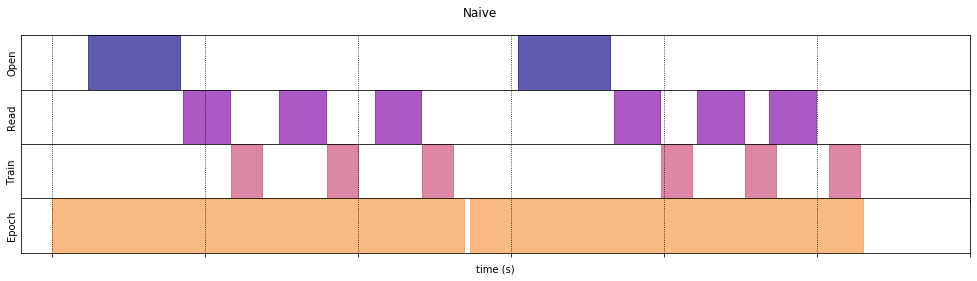

In [10]:
draw_timeline(timelined_benchmark(
    TimeMeasuredDataset()
), "Naive", 0.3)

Execution time: 0.22739008099597413


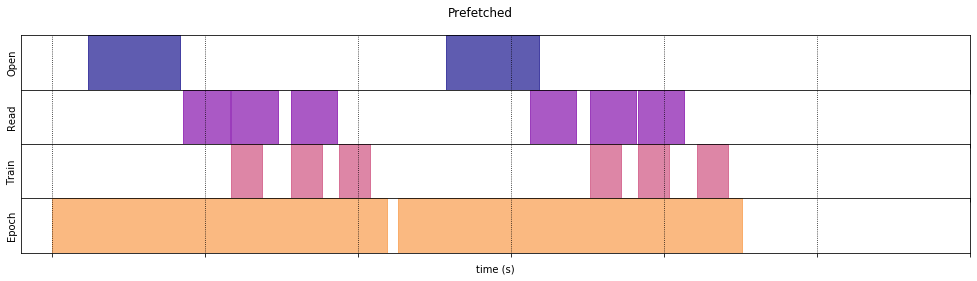

In [11]:
draw_timeline(timelined_benchmark(
    TimeMeasuredDataset()
    .prefetch(tf.data.experimental.AUTOTUNE)
), "Prefetched", 0.3)

Execution time: 0.5460015459975693


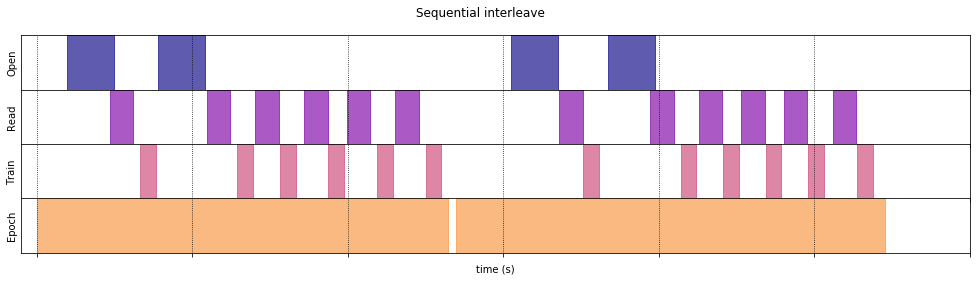

In [12]:
draw_timeline(timelined_benchmark(
    tf.data.Dataset.range(2)
    .interleave(TimeMeasuredDataset)
), "Sequential interleave", 0.6)

Execution time: 0.3289647820056416


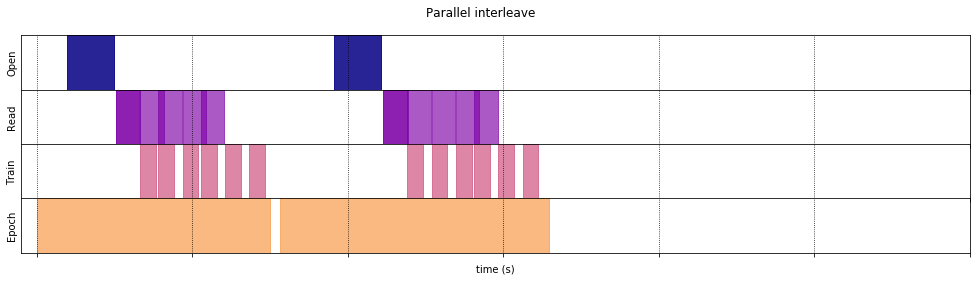

In [13]:
draw_timeline(timelined_benchmark(
    tf.data.Dataset.range(2)
    .interleave(
        TimeMeasuredDataset,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
), "Parallel interleave", 0.6)

In [14]:
def mapped_function(s):
    # Do some hard pre-processing
    for _ in range(1000):
        s = -s
    return s

@map_decorator
def timelined_mapped_function(steps, times, values):
    # Do some hard pre-processing
    map_enter = time.perf_counter()
    values = mapped_function(values)
    map_elapsed = time.perf_counter() - map_enter

    return (
        tf.concat((steps, [["Map"]]), axis=0),
        tf.concat((times, [[map_enter, map_elapsed]]), axis=0),
        tf.concat((values, [values[-1]]), axis=0)
    )

Execution time: 0.39897790400573285


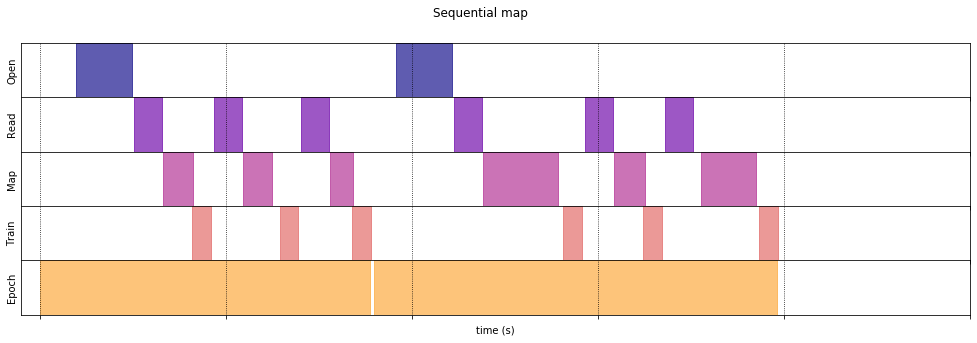

In [16]:
draw_timeline(timelined_benchmark(
    TimeMeasuredDataset()
    .map(timelined_mapped_function)
), "Sequential map", 0.5)

Execution time: 0.3802844499950879


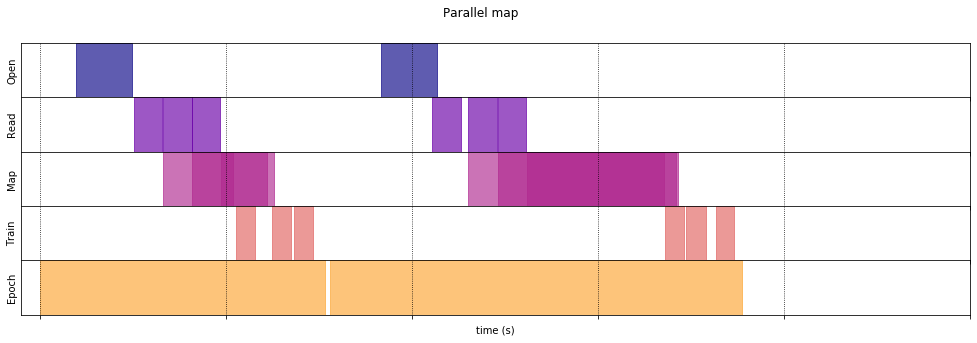

In [17]:
draw_timeline(timelined_benchmark(
    TimeMeasuredDataset()
    .map(
        timelined_mapped_function,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
), "Parallel map", 0.5, save=True)

Execution time: 0.4488071699961438


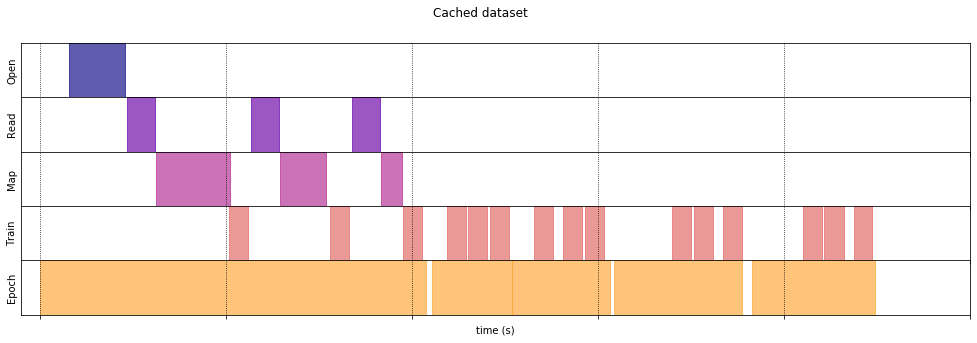

In [18]:
draw_timeline(timelined_benchmark(
    TimeMeasuredDataset()
    .map(timelined_mapped_function)
    .cache(),
    5
), "Cached dataset", 0.5, save=True)

## Pipelines comparison

In [19]:
_batch_map_num_items = 25

naive_timeline = timelined_benchmark(
    tf.data.Dataset.range(2)
    .flat_map(lambda _: TimeMeasuredDataset(num_samples=_batch_map_num_items))
    .map(naive_map)
    .batch(_batch_map_num_items, drop_remainder=True)
    .unbatch(),
    5
)

optimized_timeline = timelined_benchmark(
    tf.data.Dataset.range(2)
    .interleave(  # Parallelize data reading
        lambda _: TimeMeasuredDataset(num_samples=_batch_map_num_items),
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(  # Vectorize your mapped function
        _batch_map_num_items,
        drop_remainder=True)
    .map(  # Parallelize map transformation
        time_consumming_map,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .cache()  # Cache data
    .map(  # Reduce memory usage
        memory_consumming_map,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .prefetch(  # Overlap producer and consumer works
        tf.data.experimental.AUTOTUNE
    )
    .unbatch(),
    5
)

Execution time: 7.502062368002953
Execution time: 3.9690995330020087


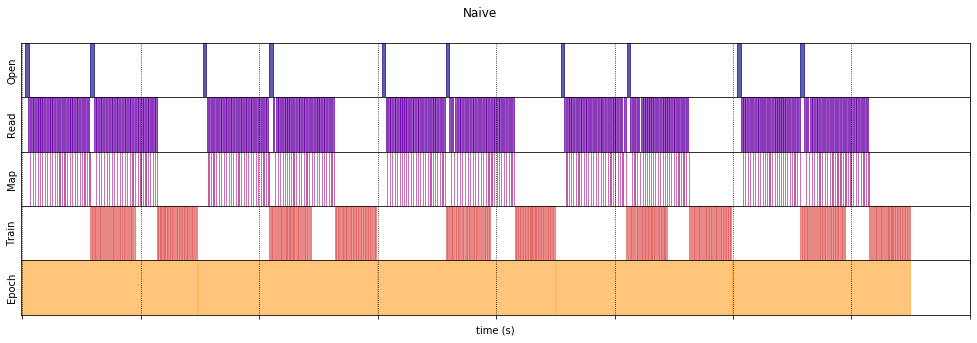

In [20]:
draw_timeline(naive_timeline, "Naive", 8)

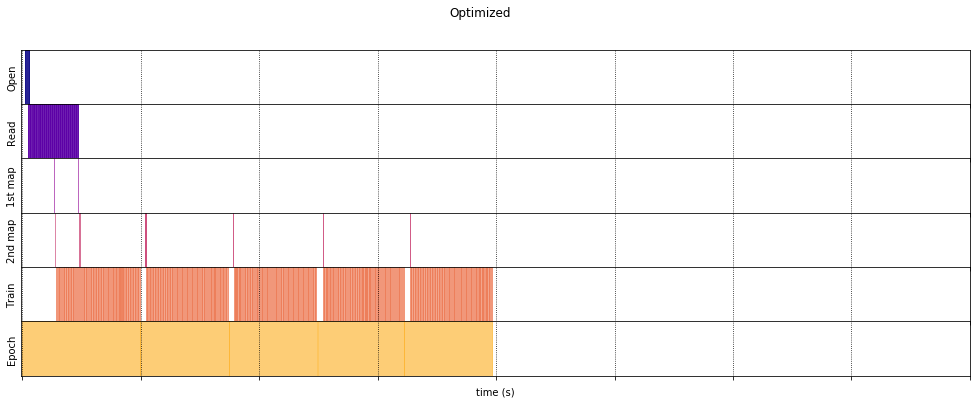

In [21]:
draw_timeline(optimized_timeline, "Optimized", 8)